Generating PSF Library for 20 depth layers...
  Processed Depth: 20.00m
  Processed Depth: 20.00m
  Processed Depth: 3.22m
  Processed Depth: 3.22m
  Processed Depth: 1.75m
  Processed Depth: 1.75m
  Processed Depth: 1.20m
  Processed Depth: 1.20m
  Processed Depth: 0.92m
  Processed Depth: 0.92m
  Processed Depth: 0.74m
  Processed Depth: 0.74m
  Processed Depth: 0.62m
  Processed Depth: 0.62m
  Processed Depth: 0.53m
  Processed Depth: 0.53m
  Processed Depth: 0.47m
  Processed Depth: 0.47m
  Processed Depth: 0.42m
  Processed Depth: 0.42m
  Processed Depth: 0.38m
  Processed Depth: 0.38m
  Processed Depth: 0.34m
  Processed Depth: 0.34m
  Processed Depth: 0.31m
  Processed Depth: 0.31m
  Processed Depth: 0.29m
  Processed Depth: 0.29m
  Processed Depth: 0.27m
  Processed Depth: 0.27m
  Processed Depth: 0.25m
  Processed Depth: 0.25m
  Processed Depth: 0.24m
  Processed Depth: 0.24m
  Processed Depth: 0.22m
  Processed Depth: 0.22m
  Processed Depth: 0.21m
  Processed Depth: 0.21m
  

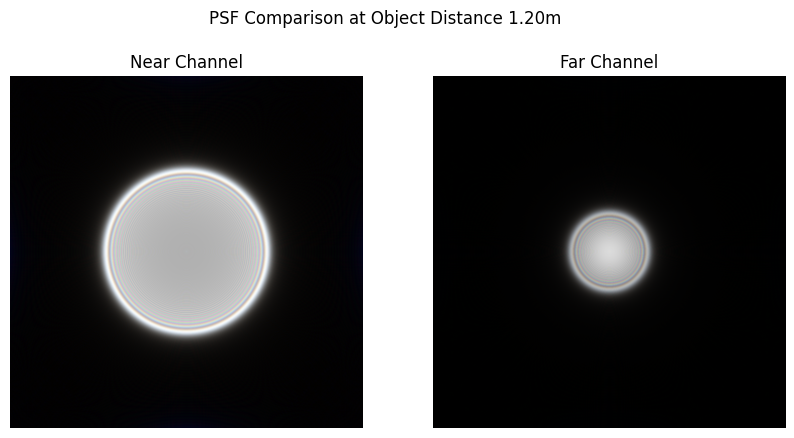

In [45]:
import numpy as np
import torch
import poppy
import astropy.units as u
import matplotlib.pyplot as plt

# ==========================================
# 1. 基础工具函数 (复用之前的逻辑)
# ==========================================
def calc_defocus_wfe(d_obj, d_focus, f_mm, f_number):
    """计算物理离焦导致的波前误差 (Meters)"""
    # 处理无穷远
    inv_d_obj = 0.0 if d_obj == float('inf') else 1.0 / d_obj
    inv_d_focus = 1.0 / d_focus

    # 屈光度差 -> 波前误差 W20
    # W ≈ (f^2 / 8*N^2) * delta_D
    f_m = f_mm * 1e-3
    w_pv = (f_m**2 / (8.0 * f_number**2)) * (inv_d_obj - inv_d_focus)
    return w_pv

def generate_single_psf(d_obj, d_focus, zernike_opt, wavelength, f_mm, f_number, pixel_size, fov_pixels):
    """生成单波长 PSF"""
    pupil_diam = (f_mm * u.mm) / f_number

    osys = poppy.OpticalSystem()
    osys.add_pupil(poppy.CircularAperture(radius=pupil_diam/2))

    # --- 组合相位 ---
    # 1. 物理离焦 (Focus Term)
    w_defocus = calc_defocus_wfe(d_obj, d_focus, f_mm, f_number)

    # 2. EDoF 优化项 (Zernike Term)
    # 复制系数表，避免污染原始字典
    coeffs = zernike_opt.copy() if zernike_opt else {}

    # 将物理离焦叠加到 Z4 (Defocus) 上
    # 注意: poppy 的系数是振幅，可以直接叠加
    coeffs[4] = coeffs.get(4, 0.0) + w_defocus

    # 转为列表传给 Poppy
    max_idx = max(coeffs.keys()) if coeffs else 4
    c_list = [0.0] * max(max_idx, 4)
    for k, v in coeffs.items():
        if k > 0: c_list[k-1] = v

    osys.add_pupil(poppy.ZernikeWFE(coefficients=c_list, radius=pupil_diam/2))

    # --- 探测器设置 (物理 -> 角度) ---
    # 25mm 镜头: 3.45um 像素对应的视场角
    pixel_scale = (pixel_size * u.m / (f_mm * u.mm)).to(u.arcsec, equivalencies=u.dimensionless_angles())
    osys.add_detector(pixelscale=pixel_scale/u.pixel, fov_pixels=fov_pixels)

    # 计算
    psf = osys.calc_psf(wavelength=wavelength, display_intermediates=False)
    return psf[0].data

def generate_rgb_psf_tensor(d_obj, d_focus, zernike_opt, **kwargs):
    """生成 RGB 三通道 PSF Tensor [3, H, W]"""
    # 典型波长
    waves = [630e-9, 550e-9, 470e-9] # R, G, B
    channels = []

    for w in waves:
        psf = generate_single_psf(d_obj, d_focus, zernike_opt, wavelength=w, **kwargs)
        channels.append(psf)

    return np.stack(channels, axis=0) # [3, H, W]

# ==========================================
# 2. 主执行逻辑：生成两组 PSF
# ==========================================
def main():
    # --- 硬件参数 ---
    f_len = 25.0  # 25mm
    f_num = 2.8  # F2.8
    pix_size = 3.45e-6  # IMX264 像元
    psf_size = 512  # PSF 尺寸

    # --- EDoF 优化系数 (关键步骤) ---
    # 假设这是你网络优化出来的、或者是 Zemax 算出来的球差值
    # Z11 = 150nm (这是一个经验值，用于产生 EDoF 效果)
    # Z4 = 0 (因为物理对焦由 d_focus 控制)
    edof_coeffs = {11: 150e-9}

    # --- 定义深度层 (0.2m - 20m) ---
    # 在屈光度空间均匀采样 20 层
    diopters = np.linspace(1 / 20.0, 1 / 0.2, 20)
    depths = 1.0 / diopters  # [20.0, ..., 0.2]

    print(f"Generating PSF Library for {len(depths)} depth layers...")

    # 容器
    bank_near = []  # 0.5m 焦点组
    bank_far = []  # 3.0m 焦点组

    for d in depths:
        # 1. 生成 Near 通道 (Focus = 0.5m)
        # 注意：这里传入了 edof_coeffs，实现了“在 0.5m 处扩展景深”
        psf_n = generate_rgb_psf_tensor(d_obj=d,
                                        d_focus=0.5,
                                        zernike_opt=edof_coeffs,
                                        f_mm=f_len,
                                        f_number=f_num,
                                        pixel_size=pix_size,
                                        fov_pixels=psf_size)
        psf_n = psf_n / psf_n.sum()  # 归一化
        bank_near.append(psf_n)

        # 2. 生成 Far 通道 (Focus = 3.0m)
        # 同样传入 edof_coeffs，实现了“在 3.0m 处扩展景深”
        psf_f = generate_rgb_psf_tensor(d_obj=d,
                                        d_focus=3.0,
                                        zernike_opt=edof_coeffs,
                                        f_mm=f_len,
                                        f_number=f_num,
                                        pixel_size=pix_size,
                                        fov_pixels=psf_size)
        psf_f = psf_f / psf_f.sum()
        bank_far.append(psf_f)
        print(f"  Processed Depth: {d:.2f}m")

    # 转为 Tensor
    psf_bank_near = torch.tensor(np.array(bank_near),
                                 dtype=torch.float32)  # [K, 3, H, W]
    psf_bank_far = torch.tensor(np.array(bank_far),
                                dtype=torch.float32)  # [K, 3, H, W]

    print("\nGeneration Complete!")
    print(f"Near Bank Shape: {psf_bank_near.shape}")
    print(f"Far Bank Shape:  {psf_bank_far.shape}")

    # --- 可视化对比 (取中间某一层) ---
    mid_idx = 3
    d_val = depths[mid_idx]
    
    # 提取图像数据
    img_near = psf_bank_near[mid_idx].permute(1,2,0).numpy()
    img_far  = psf_bank_far[mid_idx].permute(1,2,0).numpy()
    
    # 【关键修正】归一化到 0-1 之间，否则看起来是黑的
    img_near = img_near / (img_near.max() + 1e-8)
    img_far  = img_far / (img_far.max() + 1e-8)

    plt.figure(figsize=(10, 5))
    plt.suptitle(f"PSF Comparison at Object Distance {d_val:.2f}m")
    
    plt.subplot(1, 2, 1)
    plt.title("Near Channel")
    plt.imshow(img_near ** 0.5) # Gamma 0.5 提亮暗部
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Far Channel")
    plt.imshow(img_far ** 0.5)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

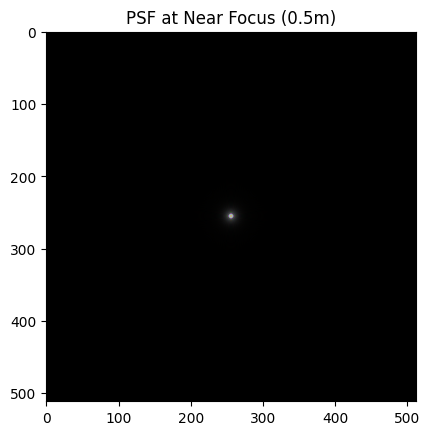

In [46]:

psf_near_focus = generate_rgb_psf_tensor(d_obj=0.5,
                                         d_focus=0.5,
                                         zernike_opt={11: 150e-9},
                                         f_mm=25.0,
                                         f_number=2.8,
                                         pixel_size=3.45e-6,
                                         fov_pixels=256)
psf_near_focus = psf_near_focus / psf_near_focus.sum()
image_psf_near_focus = psf_near_focus.transpose(1,2,0)
image_psf_near_focus = image_psf_near_focus / (image_psf_near_focus.max() +
                                               1e-8)
plt.imshow(image_psf_near_focus**0.5)
plt.title("PSF at Near Focus (0.5m)")
plt.show()

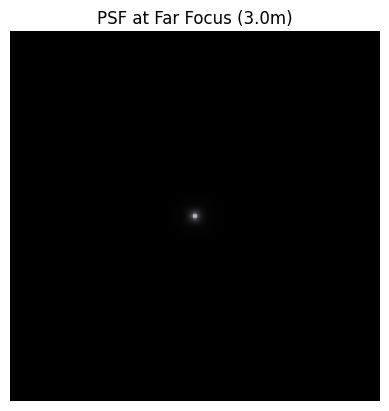

In [47]:
psf_far_focus = generate_rgb_psf_tensor(d_obj=3.0,
                                        d_focus=3.0,
                                        zernike_opt={11: 150e-9},
                                        f_mm=25.0,
                                        f_number=2.8,
                                        pixel_size=3.45e-6,
                                        fov_pixels=256)
psf_far_focus = psf_far_focus / psf_far_focus.sum()
image_psf_far_focus = psf_far_focus.transpose(1, 2, 0)
image_psf_far_focus = image_psf_far_focus / (image_psf_far_focus.max() + 1e-8)
plt.imshow(image_psf_far_focus**0.5)

plt.title("PSF at Far Focus (3.0m)")
plt.axis('off')
plt.show()